Recommender Systems - Repair Project Component - Group 8
Sebas van Sluijsdam
i6252182

Assignment:
Your evaluation should answer the following research question: Are there any differences in the performances of a group recommender using the average satisfaction strategy related to the size of the groups?

To answer this research question you should perform an offline evaluation following the pipeline shown in lab 2 - you can find the slides of the pipeline on the Group Recommenders lecture on Canvas.

 

Consider the following additional instructions:

1.       You must use the dataset provided for tutorial 1 ( https://github.com/barnap/recsys-um-lab1-2022-public ). It contains information about the evaluation of users for certain movies, and the subtitles of such movies.

2.       Focus only on random groups of size 2, 3 and 5; you have to implement the generation of random groups of size 2, 3, and 5 from your dataset.

3.       You must use an Hold-out validation strategy (80% for the training, 20% for the test set).

4.       As showed in the tutorial 1, you can train both a CF strategy and a CB strategy with the given datasets. Choose one of the two strategies proposed in the tutorial 1, for providing individual recommendations for the group members. You can adapt the source code provided in the tutorial for this.

5.       The group aggregation strategy to evaluate is the “average satisfaction”.

6.       Use a decoupled evaluation setting and the nDCG metric for your evaluation (consider recommendation lists of 5 items).

Import the datasets into a pandas dataframe

In [105]:
import pandas as pd
import random
import numpy as np


movies_path = 'preprocessed_dataset/movies.csv'
ratings_path = 'preprocessed_dataset/ratings.csv'


ratings_df = pd.read_csv(ratings_path) 
display(ratings_df.head(10))

movies_df = pd.read_csv(movies_path, index_col="item")
display(movies_df.head(10))

,user,item,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,70,3.0,964982400
4,1,101,5.0,964980868
5,1,110,4.0,964982176
6,1,151,5.0,964984041
7,1,157,5.0,964984100
8,1,163,5.0,964983650
9,1,216,5.0,964981208


,title,year,genres,plot
item,,,,
1,toy story,1995,Adventure|Animation|Children|Comedy|Fantasy,In a world where toys are living things who pr...
2,jumanji,1995,Adventure|Children|Fantasy,"In 1869, near Brantford, New Hampshire, two br..."
3,grumpier old men,1995,Comedy|Romance,The feud between Max (Walter Matthau) and John...
4,waiting to exhale,1995,Comedy|Drama|Romance,"""Friends are the People who let you be yoursel..."
5,father of the bride part ii,1995,Comedy,The film begins five years after the events of...
6,heat,1995,Action|Crime|Thriller,"Neil McCauley, a career criminal, hires Waingr..."
7,sabrina,1995,Comedy|Romance,Sabrina Fairchild is the young daughter of the...
8,tom and huck,1995,Adventure|Children,The movie opens with Injun Joe (Eric Schweig) ...
9,sudden death,1995,Action,Darren McCord (Jean-Claude Van Damme) is a Fre...


First we create all necessary functions to perform the group creation and the hold-out validation (with a 80:20 ratio) to create a train and test set.

In [106]:
# Function to split a group into a train and test set
def split_users(user_range, ratio=0.8):
    user_ids = list(range(user_range[0], user_range[1] + 1))
    random.shuffle(user_ids)
    split_index = int(len(user_ids) * ratio)
    train_set = user_ids[:split_index]
    test_set = user_ids[split_index:]
    return train_set, test_set

# Function to generate group of a given size
def generate_groups(user_ids,size):

    # Split the list into groups of the specified size
    groups = [user_ids[i:i + size] for i in range(0, len(user_ids), size) if len(user_ids[i:i + size]) == size]

    return groups

# Retrieve the user-item interactions for all users in the group
def user_item_interactions(df,groups):

    all_interactions = pd.DataFrame()
    try:
        for group in groups:
            group_interactions = df[df['user'].isin(group)]
            all_interactions = pd.concat([all_interactions, group_interactions])
    except TypeError:
        all_interactions = df[df['user'].isin(groups)]

    return all_interactions


Now we will use these functions to create our synthethic groups and train/test split.
We first create a train/test split, and afterwards we create the groups. We do this to ensure that all users in a group are either in the train or test data and never in both.
This ensures that that if one member of a group is in the test set, then all are, and they all have the same pool of items for which predictions need to be made.
Because we create groups of random size, we are not concerned in preserving existing user relationships or characteristics within a group. Making this a viable strategy.  

In [107]:
# Split users into train and test sets
train_users, test_users = split_users((1, 610))

# Generate groups from train and test sets
train_groups2 = generate_groups(train_users, 2)
test_groups2 = generate_groups(test_users, 2)

train_groups3 = generate_groups(train_users, 3)
test_groups3 = generate_groups(test_users, 3)

train_groups5 = generate_groups(train_users, 5)
test_groups5 = generate_groups(test_users, 5)

# Example: Print the number of groups and first 5 groups for each size
print(f"Number of train groups of size 2: {len(train_groups2)}")
print("Example train groups:", train_groups2[:5])

print(f"Number of test groups of size 2: {len(test_groups2)}")
print("Example test groups:", test_groups2[:5])

# Create dataframes of the test split in user-item interactions 
train_set = user_item_interactions(ratings_df,train_users)  
test_i2 = user_item_interactions(ratings_df,test_groups2)

test_i3 = user_item_interactions(ratings_df,test_groups3)

test_i5 = user_item_interactions(ratings_df,test_groups5)


Number of train groups of size 2: 244
Example train groups: [[9, 211], [204, 391], [544, 385], [303, 484], [494, 65]]
Number of test groups of size 2: 61
Example test groups: [[378, 252], [270, 326], [243, 471], [319, 8], [485, 294]]


Now that we have the train and test sets we can start to train a Collaborative filtering algorithm, using User-User Nearest neighbors.

In [108]:
#Source code from Tutorial Lab 1.ipynb:
from lenskit.algorithms import Recommender
from lenskit.algorithms import Predictor
from lenskit.algorithms.user_knn import UserUser

# We use the collaborative user algorithm UserUser, that use the nearest neighbors 
user_user = UserUser(15, min_nbrs=3)  # Minimum (3) and maximum (15) number of neighbors to consider
# Train the model
recsys = Recommender.adapt(user_user)
recsys.fit(train_set)

We now search for the items we want to create predictions for. We do this by getting 10% of the total amount of items, both generic items and tail items. Recommending a mix of generic and tail items can balance user engagement. Users may appreciate recommendations of familiar items (generic) while also being exposed to new and exciting options (tail), which can keep them engaged with your platform.

In [109]:
#Sort on the counts each item has been given a rating
count_ratings_df = ratings_df[['user', 'item']].groupby(['item']).filter(lambda x: len(x) > 4).groupby(['item']).count()
count_ratings_df = count_ratings_df.sort_values(by='user', ascending=False)
amount_items = len(count_ratings_df)
display(f"Amount of items with more than 1 rating: {amount_items}")

start_index = 0
skip_interval = 10

# Initialize an empty list to store the selected items
selected_items = []

while start_index < len(count_ratings_df):
    # Retrieve the selected item
    selected_item = count_ratings_df.index[start_index]

    # Append the selected item to the list
    selected_items.append(selected_item)

    # Increment the start index by the skip interval to get the next item
    start_index += skip_interval

# Convert the list of selected items to a DataFrame

# Display the selected items
print(selected_items[:5])



'Amount of items with more than 1 rating: 2305'

[356, 592, 648, 1704, 10]


We have a list of all items we want to make a prediction for, so now we can start making the predictions for all 3 group sizes.

In [126]:
def predict_ratings( item_ids,interactions_df):
    all_predictions = []
    # Loop through all users
    for user_id in interactions_df['user'].unique():
        user_interactions = interactions_df[interactions_df['user'] == user_id]

        # Convert to pandas Series with item as index and rating as values
        user_ratings = user_interactions.set_index('item')['rating']

        # Predict ratings using the recommender system
        # Add predictions to a df
        predicted_ratings = recsys.predict_for_user(user_id, item_ids, ratings=user_ratings)
        predictions_df = predicted_ratings.to_frame(name='predicted_rating').reset_index()
        predictions_df['user'] = user_id
        all_predictions.append(predictions_df)

    return pd.concat(all_predictions, ignore_index=True)
# Make the predictions
predicted_ratings2 = predict_ratings(selected_items, test_i2)
predicted_ratings3 = predict_ratings(selected_items, test_i3)
predicted_ratings5 = predict_ratings(selected_items, test_i5)
print(f"First 5 rows of our predictions: \n { predicted_ratings2[:5]} ")

First 5 rows of our predictions: 
          item  predicted_rating  user
0         356          4.868218   252
1         592          3.840692   252
2         648          4.176156   252
3        1704          4.578722   252
4          10          4.163091   252
...       ...               ...   ...
28177  102033          3.530410   369
28178  104243          2.860146   369
28179    3871               NaN   369
28180   93272          2.704089   369
28181    1785          3.870222   369

[28182 rows x 3 columns] 


Next, we are going to do a group aggregation with average satisfaction, considering recommendation lists of 5 items. 

In [114]:
def group_aggregation(predicted_ratings, groups, num_items=5):
    group_recommendations = {}

    for i, group in enumerate(groups):
        # Filter the predictions for users in the current group
        group_predictions = predicted_ratings[predicted_ratings['user'].isin(group)]

        # Calculate average satisfaction score for each item
        avg_satisfaction = group_predictions.groupby('item')['predicted_rating'].mean()

        # Select top 'num_items' items based on average satisfaction
        top_items = avg_satisfaction.nlargest(num_items).index.tolist()

        # Store the recommendations for the group
        group_recommendations[i] = top_items

    return group_recommendations

# Create the group recommendations for all different group sizes
group_recommendations2 = group_aggregation(predicted_ratings2, test_groups2)
group_recommendations3 = group_aggregation(predicted_ratings3, test_groups3)
group_recommendations5 = group_aggregation(predicted_ratings5, test_groups5)
# Print the recommendations of group size 2 for visualisation
print(group_recommendations2)

{0: [2261, 2730, 3030, 5500, 106766], 1: [3030, 3983, 356, 1096, 750], 2: [3030, 1103, 5500, 104879, 1096], 3: [1931, 5500, 1921, 750, 3030], 4: [750, 356, 3030, 1611, 1103], 5: [356, 2261, 5500, 1103, 750], 6: [3030, 5500, 104879, 3983, 933], 7: [3030, 3983, 750, 1274, 1921], 8: [750, 1274, 933, 356, 4011], 9: [750, 5500, 918, 1288, 1921], 10: [3030, 5339, 93272, 1921, 933], 11: [3030, 3983, 104879, 2261, 1096], 12: [501, 750, 5500, 55442, 97304], 13: [356, 5500, 1096, 2730, 3030], 14: [1096, 918, 3030, 3983, 1103], 15: [1096, 356, 1967, 5500, 1921], 16: [1096, 918, 1288, 3030, 1266], 17: [1096, 3030, 3983, 5500, 1103], 18: [194, 933, 3983, 2730, 98961], 19: [3030, 5500, 918, 104879, 933], 20: [5500, 1103, 1096, 933, 750], 21: [3030, 949, 3983, 1096, 501], 22: [3030, 1096, 3983, 750, 55442], 23: [3030, 3983, 750, 1103, 1704], 24: [3030, 5500, 1967, 933, 104879], 25: [3983, 1785, 933, 1103, 5500], 26: [750, 1274, 918, 1096, 356], 27: [1096, 1921, 933, 750, 1266], 28: [3030, 1096, 918, 

In [128]:

def ndcg(relevance_scores, k=5):
    # Convert relevance_scores to array \
    relevance_scores = np.array(relevance_scores)
        
    # Compute DCG
    dcg = relevance_scores[0] + np.sum(relevance_scores[1:] / np.log2(np.arange(2, relevance_scores.size + 1)))

    # Compute IDCG
    ideal_relevance_scores = np.sort(relevance_scores)[::-1]
    idcg = ideal_relevance_scores[0] + np.sum(ideal_relevance_scores[1:] / np.log2(np.arange(2, ideal_relevance_scores.size + 1)))

    # nDCG
    return dcg / idcg if idcg > 0 else 0



def evaluate_groups(predicted_ratings_df, groups, group_recommendations):
    ndcg_scores = []

    for idx, group in enumerate(groups):
        # Get all predicted ratings for items recommended to the group members
        group_pred_ratings = predicted_ratings_df[predicted_ratings_df['user'].isin(group)]
        
        # Create a dictionary from the item-predicted_rating pairs for easy lookup
        item_rating_dict = dict(zip(group_pred_ratings['item'], group_pred_ratings['predicted_rating']))

        # Get the list of recommendations for the current group using the group index
        recommendations = group_recommendations[idx]

        # Create the relevance scores list for the recommended items for this group
        relevance_scores = [item_rating_dict.get(item, 0) for item in recommendations]

        # Compute nDCG for the group and append to the list
        group_ndcg = ndcg( relevance_scores)
        ndcg_scores.append(group_ndcg)

    # Average nDCG across all groups
    avg_ndcg = np.mean(ndcg_scores)

    return avg_ndcg

# Convert group_recommendations from dictionary to list of lists
group_recommendations_list2 = list(group_recommendations2.values())
average_ndcg = evaluate_groups(predicted_ratings2, test_groups2, group_recommendations_list2)
print(f"Average nDCG for all groups of size 2: {average_ndcg}")

group_recommendations_list3 = list(group_recommendations2.values())
average_ndcg = evaluate_groups(predicted_ratings3, test_groups3, group_recommendations_list3)
print(f"Average nDCG for all groups of size 3: {average_ndcg}")

group_recommendations_list5 = list(group_recommendations2.values())
average_ndcg = evaluate_groups(predicted_ratings5, test_groups5, group_recommendations_list5)
print(f"Average nDCG for all groups of size 5: {average_ndcg}")



Average nDCG for all groups of size 2: 0.7664324604005274
Average nDCG for all groups of size 3: 0.8123768153032932
Average nDCG for all groups of size 5: 0.6990185352457589


In [136]:
num_runs= 500
def run_everything(runs,n):
    all_ndcg_scores = []
    for run in range(runs):
        train_users, test_users = split_users((1, 610))
        test_groups = generate_groups(test_users, n)
        train_set = user_item_interactions(ratings_df,train_users)  
        test_i = user_item_interactions(ratings_df,test_groups)
        recsys.fit(train_set)
        predicted_ratings = predict_ratings(selected_items, test_i)
        group_recommendations = group_aggregation(predicted_ratings, test_groups)
        group_recommendations_list = list(group_recommendations.values())
        average_ndcg = evaluate_groups(predicted_ratings, test_groups, group_recommendations_list)
        all_ndcg_scores.append(average_ndcg)
    return all_ndcg_scores

all_2_scores = run_everything(num_runs,2)
all_3_scores = run_everything(num_runs,3)
all_5_scores = run_everything(num_runs,5)

ANOVA Test: F-value = 137.93336408461653 , P-value = 1.0458382141496572e-55


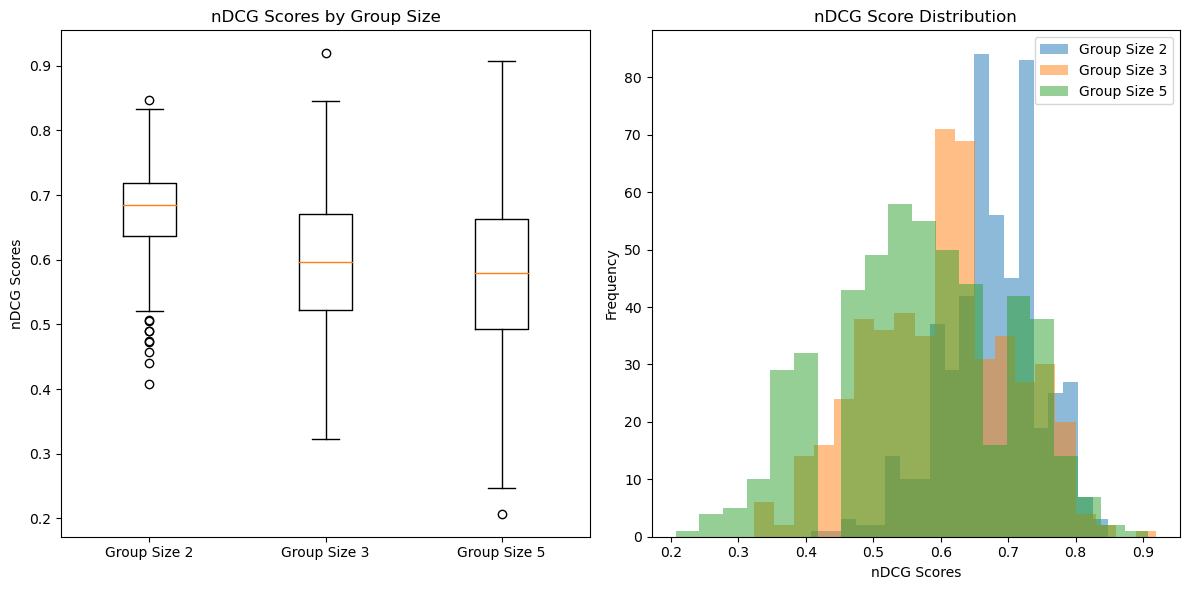

In [140]:
import matplotlib.pyplot as plt
import scipy.stats as stats


ndcg_scores_group_2 = all_2_scores  
ndcg_scores_group_3 = all_3_scores  
ndcg_scores_group_5 = all_5_scores 

# Perform an ANOVA test to see if there's a significant difference in means
f_value, p_value = stats.f_oneway(ndcg_scores_group_2, ndcg_scores_group_3, ndcg_scores_group_5)
print("ANOVA Test: F-value =", f_value, ", P-value =", p_value)

# Visualization - Boxplot and Histogram
plt.figure(figsize=(12, 6))

# Boxplot for nDCG scores
plt.subplot(1, 2, 1)
plt.boxplot([ndcg_scores_group_2, ndcg_scores_group_3, ndcg_scores_group_5], labels=['Group Size 2', 'Group Size 3', 'Group Size 5'])
plt.title('nDCG Scores by Group Size')
plt.ylabel('nDCG Scores')

# Histograms for each group size
plt.subplot(1, 2, 2)
plt.hist(ndcg_scores_group_2, alpha=0.5, bins=20, label='Group Size 2')
plt.hist(ndcg_scores_group_3, alpha=0.5, bins=20, label='Group Size 3')
plt.hist(ndcg_scores_group_5, alpha=0.5, bins=20, label='Group Size 5')
plt.title('nDCG Score Distribution')
plt.xlabel('nDCG Scores')
plt.ylabel('Frequency')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

F-value, P-value:
The very small P-value, together with the high F-value, provides very strong evidence against the null hypothesis. The null hypothesis for an ANOVA test is that there are no differences among the group means. Thus, we can confidently reject the null hypothesis and conclude that there are significant differences in the means of the groups. Thus the performance varies significantly depending on the group. 

Boxplot:
We observe that the median for group size 2 is a bit higher than that of group size 3 and 5, which are almost the same.
Group size 2 appears to have a tighter IQR compared to group sizes 3 and 5, suggesting less variability in the nDCG scores. In comparison, the IQR for group size 5 is larger, indicating greater variability in the scores. 
The circles represent outliers, which group size 2 seems to have the most of.
The median of group size 2 is a bit closer to the top than bottom, suggesting that the distribution is skewed downwards.

Histogram:
Group size 2 has a peak at higher nDCG scores indicating more frequent higher performance. Group size 5 shows a wider spread of scores, with substantial frequency in the mid-range of scores. Group size 3 is intermediate between the two in terms of score frequency and spread.

This variability and the presence of outliers could be due to the dynamics of the groups. Smaller groups might have more consistent preferences, leading to a tighter clustering of higher nDCG scores, whereas larger groups might have more diverse preferences, leading to a broader range of nDCG scores. And the group of size 3 being in the middle of both.

The significant differences indicated by the ANOVA test suggest that these are not just random fluctuations but real differences in the recommender system's performance across different group sizes.